In [1]:
import torch
from sklearn.linear_model import LinearRegression,Lasso
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

import json
import pickle
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

# Load data

In [3]:
gene_space = 'allgenes'
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_all_genes_q1_tas03.csv',index_col = 0)
if gene_space=='landmarks':
    lands = pd.read_csv('../preprocessing/preprocessed_data/cmap_landmarks_HT29_A375.csv', index_col=0)
    lands = lands.columns
    cmap = cmap.loc[:, lands]
gene_size = len(cmap.columns)
samples = cmap.index.values

In [4]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

# Define fit model

In [5]:
class FIT(object):
    
    def __init__(self, inputSize):
        
        super(FIT, self).__init__()
        
        self.num_genes = inputSize
        ### Initialize a regression model for each gene
        self.models = [LinearRegression() for i in range(inputSize)]
        
    def fit(self,x,y):
        for i in range(self.num_genes):
            if len(x[:,i].shape)<2:
                x_reshaped = np.expand_dims(x[:,i], 1)
            else:
                x_reshaped = np.copy(x[:,i])
            if len(y[:,i].shape)<2:
                y_reshaped = np.expand_dims(y[:,i], 1)
            else:
                y_reshaped = np.copy(y[:,i])
            self.models[i].fit(x_reshaped,y_reshaped)
    
    def predict(self, x):
        y = np.zeros(x.shape)
        for i in range(self.num_genes):
            if len(x[:,i].shape)<2:
                x_reshaped = np.expand_dims(x[:,i], 1)
            else:
                x_reshaped = np.copy(x[:,i])
            y[:,i:i+1] = self.models[i].predict(x_reshaped)
        return y
    
    def per_gene_r2(self,x,y):
        r2 =[]
        for i in range(self.num_genes):
            if len(x[:,i].shape)<2:
                x_reshaped = np.expand_dims(x[:,i], 1)
            else:
                x_reshaped = np.copy(x[:,i])
            if len(y[:,i].shape)<2:
                y_reshaped = np.expand_dims(y[:,i], 1)
            else:
                y_reshaped = np.copy(y[:,i])
            r2.append(self.models[i].score(x_reshaped, y_reshaped))
        return r2

# Start training one direction

In [6]:
results = {'model_pearsonHT29':[],'model_pearsonA375':[],
           'model_spearHT29':[],'model_spearA375':[],
           'model_accHT29':[],'model_accA375':[]}

In [7]:
train_results = {'model_pearsonHT29':[],'model_pearsonA375':[],
           'model_spearHT29':[],'model_spearA375':[],
           'model_accHT29':[],'model_accA375':[]}

In [8]:
trainPear = []
trainSpear = []
trainR2 =[]
trainMSE = []
trainAcc =[]

valPear = []
valSpear = []
valR2 =[]
valMSE = []
valAcc = []

for i in range(10):
    # Load data
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    N = len(trainInfo_paired)
    
    x1 = cmap.loc[trainInfo_paired['sig_id.x'],:].values
    x2 = cmap.loc[trainInfo_paired['sig_id.y'],:].values
    
    xval1 = cmap.loc[valInfo_paired['sig_id.x'],:].values
    xval2 = cmap.loc[valInfo_paired['sig_id.y'],:].values
    
    model = FIT(gene_size)    
    model.fit(x1,x2)
    y = model.predict(x1)
    
    gene_r2 = model.per_gene_r2(x1,x2)
    
    
    pearson = pearson_r(torch.tensor(y).to(device).flatten(), torch.tensor(x2).to(device).flatten())
    r2 = r_square(torch.tensor(y).to(device).flatten(), torch.tensor(x2).to(device).flatten())
    mse = torch.mean(torch.mean((torch.tensor(y).to(device)- torch.tensor(x2).to(device))**2,dim=1))
    trainMSE.append(mse.item())
    trainPear.append(pearson.item())
    trainR2.append(r2.item())
    rhos = []
    for jj in range(y.shape[0]):
        rho, p = spearmanr(x2[jj, :], y[jj, :])
        rhos.append(rho)
    trainSpear.append(np.mean(rhos))
    acc = pseudoAccuracy(torch.tensor(x2), torch.tensor(y), eps=1e-6)
    trainAcc.append(np.mean(acc))
    
    outString = 'Training: Split {:.0f}'.format(i + 1)
    outString += ', r2={:.4f}'.format(r2.item())
    outString += ', pearson={:.4f}'.format(pearson.item()) 
    outString += ', MSE={:.4f}'.format(mse.item())
    print(outString)
    
    # Validation
    yval = model.predict(xval1)
    pearson = pearson_r(torch.tensor(yval).to(device).flatten(), torch.tensor(xval2).to(device).flatten())
    r2 = r_square(torch.tensor(yval).to(device).flatten(), torch.tensor(xval2).to(device).flatten())
    mse = torch.mean(torch.mean((torch.tensor(yval).to(device)-torch.tensor(xval2).to(device))**2,dim=1))
    valMSE.append(mse.item())
    valPear.append(pearson.item())
    valR2.append(r2.item())
    rhos = []
    for jj in range(yval.shape[0]):
        rho, p = spearmanr(xval2[jj, :], yval[jj, :])
        rhos.append(rho)
    valSpear.append(np.mean(rhos))
    acc = pseudoAccuracy(torch.tensor(xval2), torch.tensor(yval), eps=1e-6)
    valAcc.append(np.mean(acc))
    
    outString = 'Validation: Split {:.0f}'.format(i + 1)
    outString += ', r2={:.4f}'.format(r2.item())
    outString += ', pearson={:.4f}'.format(pearson.item()) 
    outString += ', MSE={:.4f}'.format(mse.item())
    print(outString)
    
    with open('../results/FITmodel_results/models_noReg/FITmodel_'+gene_space+'_a375_ht29_%s.pkl'%i, 'wb') as outp:
        pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

Training: Split 1, r2=-1.7354, pearson=0.5174, MSE=0.8675
Validation: Split 1, r2=-1.2886, pearson=0.5679, MSE=0.7979
Training: Split 2, r2=-1.6522, pearson=0.5233, MSE=0.8645
Validation: Split 2, r2=-1.4049, pearson=0.5186, MSE=0.8230
Training: Split 3, r2=-1.7132, pearson=0.5190, MSE=0.8557
Validation: Split 3, r2=-1.7027, pearson=0.5526, MSE=0.9062
Training: Split 4, r2=-1.6463, pearson=0.5237, MSE=0.8700
Validation: Split 4, r2=-1.3596, pearson=0.5151, MSE=0.7716
Training: Split 5, r2=-1.7813, pearson=0.5143, MSE=0.8356
Validation: Split 5, r2=-1.9169, pearson=0.5724, MSE=1.1022
Training: Split 6, r2=-1.6335, pearson=0.5246, MSE=0.8498
Validation: Split 6, r2=-2.0021, pearson=0.5075, MSE=0.9563
Training: Split 7, r2=-1.5320, pearson=0.5321, MSE=0.8533
Validation: Split 7, r2=-2.3398, pearson=0.4262, MSE=0.9266
Training: Split 8, r2=-1.6841, pearson=0.5210, MSE=0.8537
Validation: Split 8, r2=-2.3183, pearson=0.5419, MSE=0.9236
Training: Split 9, r2=-1.5104, pearson=0.5337, MSE=0.870

(array([1.815e+03, 3.498e+03, 2.579e+03, 1.264e+03, 5.810e+02, 2.270e+02,
        8.400e+01, 3.100e+01, 5.000e+00, 2.000e+00]),
 array([5.20904098e-10, 6.53263518e-02, 1.30652703e-01, 1.95979054e-01,
        2.61305405e-01, 3.26631757e-01, 3.91958108e-01, 4.57284459e-01,
        5.22610810e-01, 5.87937162e-01, 6.53263513e-01]),
 <BarContainer object of 10 artists>)

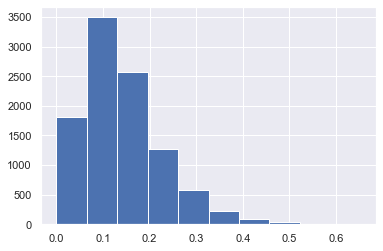

In [9]:
plt.hist(gene_r2)

In [10]:
print(np.mean(valPear))
print(np.mean(trainPear))

0.5083917558496507
0.5235651206077003


In [11]:
print(np.mean(valSpear))
print(np.mean(valAcc))

0.41503598408212383
0.6416257683918303


(array([1.700e+01, 2.160e+02, 1.181e+03, 3.289e+03, 3.191e+03, 1.467e+03,
        5.880e+02, 1.090e+02, 2.600e+01, 2.000e+00]),
 array([-0.10201941,  0.00810842,  0.11823624,  0.22836406,  0.33849188,
         0.44861971,  0.55874753,  0.66887535,  0.77900317,  0.889131  ,
         0.99925882]),
 <BarContainer object of 10 artists>)

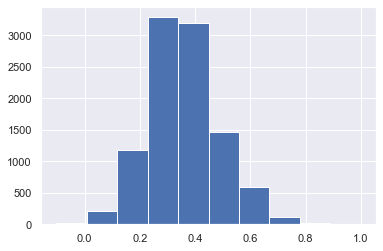

In [12]:
slopes = []
intercepts = []
for i in range(gene_size):
    slopes.append(model.models[i].coef_[0][0])
    intercepts.append(model.models[i].intercept_[0])
plt.hist(slopes)

(array([6.000e+00, 2.300e+01, 4.900e+02, 6.316e+03, 3.181e+03, 5.500e+01,
        1.300e+01, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([-2.18400625, -1.6048168 , -1.02562735, -0.4464379 ,  0.13275155,
         0.71194099,  1.29113044,  1.87031989,  2.44950934,  3.02869879,
         3.60788824]),
 <BarContainer object of 10 artists>)

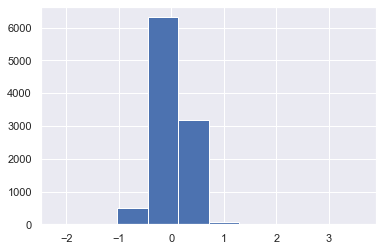

In [13]:
plt.hist(intercepts)

In [14]:
results['model_pearsonHT29'] = valPear
results['model_spearHT29'] = valAcc
results['model_accHT29'] = valSpear

In [15]:
train_results['model_pearsonHT29'] = trainPear
train_results['model_spearHT29'] = trainAcc
train_results['model_accHT29'] = trainSpear

# Train for translating in the reverse direction

In [16]:
trainPear = []
trainSpear = []
trainR2 =[]
trainMSE = []
trainAcc =[]

valPear = []
valSpear = []
valR2 =[]
valMSE = []
valAcc = []

for i in range(10):
    # Load data
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    N = len(trainInfo_paired)
    
    x1 = cmap.loc[trainInfo_paired['sig_id.x'],:].values
    x2 = cmap.loc[trainInfo_paired['sig_id.y'],:].values
    
    xval1 = cmap.loc[valInfo_paired['sig_id.x'],:].values
    xval2 = cmap.loc[valInfo_paired['sig_id.y'],:].values
    
    model = FIT(gene_size)    
    model.fit(x2,x1)
    y = model.predict(x2)
    
    gene_r2 = model.per_gene_r2(x2,x1)
    
    
    pearson = pearson_r(torch.tensor(y).to(device).flatten(), torch.tensor(x1).to(device).flatten())
    r2 = r_square(torch.tensor(y).to(device).flatten(), torch.tensor(x1).to(device).flatten())
    mse = torch.mean(torch.mean((torch.tensor(y).to(device)- torch.tensor(x1).to(device))**2,dim=1))
    trainMSE.append(mse.item())
    trainPear.append(pearson.item())
    trainR2.append(r2.item())
    rhos = []
    for jj in range(y.shape[0]):
        rho, p = spearmanr(x1[jj, :], y[jj, :])
        rhos.append(rho)
    trainSpear.append(np.mean(rhos))
    acc = pseudoAccuracy(torch.tensor(x1), torch.tensor(y), eps=1e-6)
    trainAcc.append(np.mean(acc))
    
    outString = 'Training: Split {:.0f}'.format(i + 1)
    outString += ', r2={:.4f}'.format(r2.item())
    outString += ', pearson={:.4f}'.format(pearson.item()) 
    outString += ', MSE={:.4f}'.format(mse.item())
    print(outString)
    
    # Validation
    yval = model.predict(xval2)
    pearson = pearson_r(torch.tensor(yval).to(device).flatten(), torch.tensor(xval1).to(device).flatten())
    r2 = r_square(torch.tensor(yval).to(device).flatten(), torch.tensor(xval1).to(device).flatten())
    mse = torch.mean(torch.mean((torch.tensor(yval).to(device)-torch.tensor(xval1).to(device))**2,dim=1))
    valMSE.append(mse.item())
    valPear.append(pearson.item())
    valR2.append(r2.item())
    rhos = []
    for jj in range(yval.shape[0]):
        rho, p = spearmanr(xval1[jj, :], yval[jj, :])
        rhos.append(rho)
    valSpear.append(np.mean(rhos))
    acc = pseudoAccuracy(torch.tensor(xval1), torch.tensor(yval), eps=1e-6)
    valAcc.append(np.mean(acc))
    
    outString = 'Validation: Split {:.0f}'.format(i + 1)
    outString += ', r2={:.4f}'.format(r2.item())
    outString += ', pearson={:.4f}'.format(pearson.item()) 
    outString += ', MSE={:.4f}'.format(mse.item())
    print(outString)
    
    with open('../results/FITmodel_results/models_noReg/FITmodel_'+gene_space+'_ht29_a375_%s.pkl'%i, 'wb') as outp:
        pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

Training: Split 1, r2=-1.8341, pearson=0.5107, MSE=0.8816
Validation: Split 1, r2=-2.1069, pearson=0.5354, MSE=0.9550
Training: Split 2, r2=-1.8166, pearson=0.5119, MSE=0.8874
Validation: Split 2, r2=-1.9864, pearson=0.5283, MSE=0.8973
Training: Split 3, r2=-1.8744, pearson=0.5080, MSE=0.8894
Validation: Split 3, r2=-1.5761, pearson=0.5558, MSE=0.8834
Training: Split 4, r2=-1.7680, pearson=0.5152, MSE=0.8835
Validation: Split 4, r2=-2.1667, pearson=0.4980, MSE=0.9332
Training: Split 5, r2=-2.0244, pearson=0.4985, MSE=0.8686
Validation: Split 5, r2=-1.8313, pearson=0.6054, MSE=1.0852
Training: Split 6, r2=-1.7441, pearson=0.5168, MSE=0.8869
Validation: Split 6, r2=-1.5636, pearson=0.4849, MSE=0.9023
Training: Split 7, r2=-1.6387, pearson=0.5242, MSE=0.8948
Validation: Split 7, r2=-1.7031, pearson=0.3978, MSE=0.8318
Training: Split 8, r2=-1.7639, pearson=0.5154, MSE=0.9031
Validation: Split 8, r2=-1.1431, pearson=0.4990, MSE=0.7551
Training: Split 9, r2=-1.6356, pearson=0.5245, MSE=0.892

(array([1.815e+03, 3.498e+03, 2.579e+03, 1.264e+03, 5.810e+02, 2.270e+02,
        8.400e+01, 3.100e+01, 5.000e+00, 2.000e+00]),
 array([5.20903987e-10, 6.53263518e-02, 1.30652703e-01, 1.95979054e-01,
        2.61305405e-01, 3.26631757e-01, 3.91958108e-01, 4.57284459e-01,
        5.22610810e-01, 5.87937162e-01, 6.53263513e-01]),
 <BarContainer object of 10 artists>)

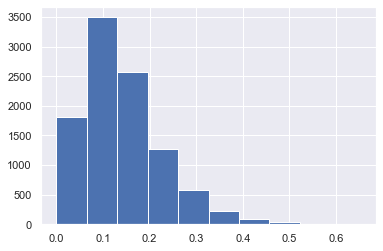

In [17]:
plt.hist(gene_r2)

In [18]:
print(np.mean(valPear))
print(np.mean(trainPear))

0.4970635650299716
0.514193422893079


In [19]:
print(np.mean(valSpear))
print(np.mean(valAcc))

0.40899470157172013
0.6431231409875074


(array([2.000e+00, 6.100e+01, 7.710e+02, 3.570e+03, 4.084e+03, 1.337e+03,
        2.230e+02, 3.000e+01, 6.000e+00, 2.000e+00]),
 array([-0.20730891, -0.07086965,  0.06556961,  0.20200887,  0.33844813,
         0.47488739,  0.61132665,  0.74776591,  0.88420517,  1.02064443,
         1.15708369]),
 <BarContainer object of 10 artists>)

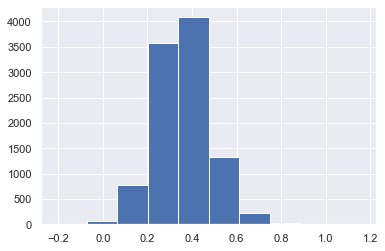

In [20]:
slopes = []
intercepts = []
for i in range(gene_size):
    slopes.append(model.models[i].coef_[0][0])
    intercepts.append(model.models[i].intercept_[0])
plt.hist(slopes)

(array([1.300e+01, 3.500e+01, 1.610e+02, 1.635e+03, 5.426e+03, 2.687e+03,
        1.040e+02, 1.300e+01, 9.000e+00, 3.000e+00]),
 array([-1.65729528, -1.28358178, -0.90986828, -0.53615478, -0.16244128,
         0.21127223,  0.58498573,  0.95869923,  1.33241273,  1.70612624,
         2.07983974]),
 <BarContainer object of 10 artists>)

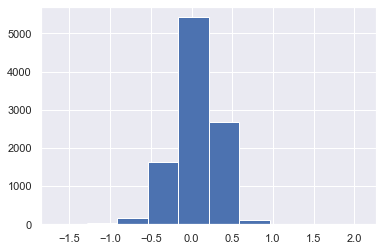

In [21]:
plt.hist(intercepts)

In [22]:
results['model_pearsonA375'] = valPear
results['model_spearA375'] = valAcc
results['model_accA375'] = valSpear

In [23]:
train_results['model_pearsonA375'] = trainPear
train_results['model_spearA375'] = trainAcc
train_results['model_accA375'] = trainSpear

In [24]:
results = pd.DataFrame(results)
display(results)
results.to_csv('../results/FITmodel_results/'+gene_space+'_10foldvalidation_FIT_a375_ht29.csv')

,model_pearsonHT29,model_pearsonA375,model_spearHT29,model_spearA375,model_accHT29,model_accA375
0,0.567878,0.535362,0.661112,0.659558,0.469136,0.452568
1,0.518642,0.528295,0.643327,0.651914,0.413772,0.424499
2,0.552603,0.555843,0.645826,0.663962,0.444486,0.465640
3,0.515140,0.498043,0.642777,0.645697,0.410375,0.404944
4,0.572400,0.605429,0.662458,0.686417,0.468119,0.511251
5,0.507485,0.484918,0.652826,0.640643,0.439214,0.406802
6,0.426178,0.397843,0.620179,0.612002,0.355160,0.333542
7,0.541904,0.499022,0.655602,0.631420,0.446650,0.387057
8,0.395360,0.383503,0.600902,0.603520,0.310104,0.312379
9,0.486326,0.482378,0.631249,0.636100,0.393344,0.391265


In [25]:
train_results = pd.DataFrame(train_results)
display(train_results)
train_results.to_csv('../results/FITmodel_results/'+gene_space+'_10foldvalidation_TrainingFIT_a375_ht29.csv')

,model_pearsonHT29,model_pearsonA375,model_spearHT29,model_spearA375,model_accHT29,model_accA375
0,0.517409,0.510703,0.642900,0.644078,0.418179,0.412086
1,0.523266,0.511871,0.644749,0.645080,0.424187,0.415480
2,0.518951,0.508041,0.644583,0.643601,0.421038,0.410976
3,0.523692,0.515161,0.645028,0.645911,0.424765,0.418073
4,0.514259,0.498482,0.642916,0.641522,0.418959,0.407224
5,0.524614,0.516804,0.643980,0.646440,0.422052,0.417930
6,0.532097,0.524235,0.647439,0.649576,0.430628,0.425441
7,0.520998,0.515443,0.643614,0.647366,0.420818,0.419519
8,0.533731,0.524460,0.649765,0.650449,0.435969,0.427539
9,0.526634,0.516733,0.646322,0.646972,0.426853,0.419521
